### 1. การติดตั้งและ Import Library

- ส่วนนี้คือการติดตั้ง library ที่จำเป็น เช่น unsloth, transformers, trl
- transformers คือ library หลักของ HuggingFace ที่มีโมเดล NLP และ Vision ที่ pretrained มาแล้ว
- trl เอาไว้ train/fine-tune โมเดลโดยใช้เทคนิค reinforcement learning หรือ supervised fine-tuning

In [1]:
# # 1) สร้างและเข้า env
# python -m venv .venv
# # Windows: .\.venv\Scripts\Activate.ps1
# # Linux/macOS: source .venv/bin/activate
# python -m pip install -U pip

# # 2) ล้างของเก่า
# pip uninstall -y torch torchvision torchaudio xformers

# # 3) ติดตั้ง PyTorch + CUDA runtime (เลือก 1 ทาง)
# pip install --index-url https://download.pytorch.org/whl/cu121 torch torchvision torchaudio
# # หรือใช้คำสั่งที่หน้า Get Started ให้มาสำหรับเวอร์ชัน CUDA ล่าสุดของคุณ

# # 4) xformers (เลือกจากล้อที่เข้ากัน)
# pip install xformers -f https://download.pytorch.org/whl/xformers/

# # 5) Unsloth
# pip install unsloth

ตรวจสอบว่า PyTorch เห็น GPU:

In [2]:
import torch, platform

print("Python:", platform.python_version())
print("Torch:", torch.__version__)
print("Built with CUDA:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

Python: 3.10.6
Torch: 2.8.0+cu129
Built with CUDA: 12.9
CUDA available: True
GPU: NVIDIA GeForce RTX 3060 Laptop GPU


### 2. โหลดโมเดล Vision-Language

- โหลดโมเดล Qwen2.5-VL (Vision-Language model) ที่สามารถเข้าใจ รูปภาพ + ข้อความ
- tokenizer ทำหน้าที่แปลงข้อความเป็นตัวเลข (tokens)
- load_in_4bit=True → ใช้ quantization 4-bit เพื่อลดขนาดโมเดลและประหยัด GPU memory

In [3]:
import unsloth
import torch, platform
from unsloth import FastVisionModel
import torch
import os
os.environ["UNSLOTH_IS_PRESENT"] = "1"

# 🧠 Load MedGemma in 4-bit Unsloth mode
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/medgemma-4b-it-unsloth-bnb-4bit",  # ✅ your new model
    load_in_4bit = True,                         # use 4-bit quantization (QLoRA ready)
    use_gradient_checkpointing = "unsloth",      # save GPU memory while training
)

# 🐉 Put the model into training or inference mode
FastVisionModel.for_training(model)   # or .for_inference(model) later
print("✅ MedGemma-4B-IT Unsloth 4bit model loaded successfully!")
print(f"Model dtype: {next(model.parameters()).dtype}")
print(f"Device: {model.device}")


f:\Lung-Captioning-main\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


W1015 10:47:18.828897 17584 Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.9.11: Fast Gemma3 patching. Transformers: 4.56.2.
   \\   /|    NVIDIA GeForce RTX 3060 Laptop GPU. Num GPUs = 1. Max memory: 6.0 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.8.0+cu129. CUDA: 8.6. CUDA Toolkit: 12.9. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Gemma3 does not support SDPA - switching to fast eager.
✅ MedGemma-4B-IT Unsloth 4bit model loaded successfully!
Model dtype: torch.bfloat16
Device: cuda:0


### 3. เพิ่ม LoRA (Low-Rank Adaptation)

- ใช้ LoRA (Low-Rank Adaptation) เพื่อ fine-tune โมเดลเฉพาะบางพารามิเตอร์ แทนที่จะ train ใหม่ทั้งหมด
- เราสามารถเลือกว่าจะฝึกเฉพาะ vision part หรือ language part ของโมเดลได้

In [4]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True,    # ✅ ให้สายภาพเรียนรู้พยาธิสภาพ/feature เฉพาะทาง
    finetune_language_layers   = False,   # ✅ รอบแรกกัน drift ภาษา (ยัง generate ได้ เพราะ head/weights ถูกใช้ตอน infer)
    finetune_attention_modules = True,    # ✅ สำคัญมากสำหรับ cross-modal alignment (ภาพ↔ข้อความ)
    finetune_mlp_modules       = False,   # ✅ ลดพารามิเตอร์ช่วงเริ่ม กัน overfit / catastrophic forgetting

    r = 16,                # ✅ เริ่มที่ 16; ถ้า underfit ค่อยขยับ 32 พร้อม rsLoRA
    lora_alpha = 16,       # ✅ อย่างน้อยเท่ากับ r ตามคำแนะนำ Unsloth
    lora_dropout = 0.15,   # ✅ ช่วยกัน overfit/โหมดเดิม (เช่นตอบ "Normal" รัว ๆ)
    bias = "none",
    random_state = 3407,

    use_rslora = True,     # ✅ เสถียรกับ rank สูง/งานยาก
    loftq_config = None,   # ✅ ถ้าเทรน 4-bit แนะนำเปิด LoftQ โปรไฟล์ C เพื่อคุณภาพ
    # target_modules = ["q_proj","k_proj","v_proj","o_proj"],  # ↔ ถ้าจะเริ่มเฉพาะ attention เท่านั้น ค่อยปลดคอมเมนต์
)

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.15.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.


Unsloth: Making `base_model.model.model.vision_tower.vision_model` require gradients


In [5]:
from datasets import load_from_disk

hf = load_from_disk("lung8_image_text")

# แบ่ง train/test (30%) ก่อน
splits = hf.train_test_split(test_size=0.3, seed=42, shuffle=True)
train_hf = splits["train"]
tmp_hf   = splits["test"]

# แบ่ง tmp ให้เป็น val/test อย่างละครึ่ง → ได้ 15/15
vt = tmp_hf.train_test_split(test_size=0.5, seed=42, shuffle=True)
val_hf  = vt["train"]
test_hf = vt["test"]

In [6]:
train_hf

Dataset({
    features: ['image', 'text', '__class__'],
    num_rows: 4259
})

In [7]:
val_hf

Dataset({
    features: ['image', 'text', '__class__'],
    num_rows: 913
})

In [8]:
# import os
# from pathlib import Path

# images_root = Path(path)
# csv_dir     = Path("prepare_data/disease_output/csv")

# print(images_root)
# print(csv_dir)
# print(os.listdir(images_root))
# print(os.listdir(csv_dir))

#### Main : dataset ของเราเอง

In [9]:
instruction = (
    "You are an expert radiologist. "
    "Describe the chest X-ray using precise clinical terms. "
    "Identify one main diagnostic category from: "
    "Chest_Changes, Degenerative_Infectious, Higher_Density, "
    "Inflammatory_Pneumonia, Lower_Density, Mediastinal_Changes, Normal, or Obstructive."
)

def convert_to_conversation(sample):
    cls_name = sample["__class__"]
    description = sample["text"]

    answer = f"Class: {cls_name}\nExplanation: {description}"

    conversation = [
        {
            "role": "system",
            "content": [{"type": "text", "text": "You are a medical image interpretation assistant."}]
        },
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": sample["image"]}
            ]
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": answer}]
        }
    ]

    return {"messages": conversation}

# Convert your datasets
train_ds      = [convert_to_conversation(sample) for sample in train_hf]
val_ds        = [convert_to_conversation(sample) for sample in val_hf]
test_ds       = [convert_to_conversation(sample) for sample in test_hf]

In [10]:
train_ds[0]

{'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You are a medical image interpretation assistant.'}]},
  {'role': 'user',
   'content': [{'type': 'text',
     'text': 'You are an expert radiologist. Describe the chest X-ray using precise clinical terms. Identify one main diagnostic category from: Chest_Changes, Degenerative_Infectious, Higher_Density, Inflammatory_Pneumonia, Lower_Density, Mediastinal_Changes, Normal, or Obstructive.'},
    {'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=450x450>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'Class: Lower_Density\nExplanation: Collapsed lung / visceral pleural line observed showing visceral pleural line with absent peripheral lung markings on the left side. A small amount of apical collapse is noted. The remaining lung fields are clear. No associated pleural effusion is present. Findings are compatible with Lower density (pneumothorax, pneumo

#### Main: 

In [11]:
from unsloth import is_bf16_supported, FastVisionModel
from unsloth.trainer import UnslothVisionDataCollator
from transformers import EarlyStoppingCallback, TrainerCallback
from trl import SFTTrainer, SFTConfig
import torch, math, random
import numpy as np
from collections import Counter
from typing import List, Dict, Any
import re
import unicodedata

In [12]:
# ==========================
# 2) ค่าตายตัวของงาน (label set) และตัวช่วยเล็ก ๆ
# ==========================
CLASS_LABELS = [
    "Chest_Changes", "Degenerative_Infectious", "Higher_Density",
    "Inflammatory_Pneumonia", "Lower_Density", "Mediastinal_Changes",
    "Normal", "Obstructive",
]
LABEL_SET = set(CLASS_LABELS)
LABEL_TO_ID = {c:i for i,c in enumerate(CLASS_LABELS)}

def extract_pred_class(text: str) -> str:
    """
    ดึงคลาสจากข้อความยาวของโมเดล:
    รับมือกรณีมีช่องว่าง/เคส/บรรทัดสลับ/มีเครื่องหมายพิเศษ
    """
    # หา "Class: <ชื่อคลาส>"
    m = re.search(r"(?i)class\s*:\s*([A-Za-z0-9_\- ]+)", text)
    if not m:
        return None
    raw = m.group(1).strip()
    # ทำ normalization เบื้องต้น
    cand = raw.replace(" ", "_")
    # เช็ค map เข้าคลาสที่รู้จัก (แบบหยวนๆ)
    # ลองตรงตัวก่อน
    if cand in LABEL_TO_ID: 
        return cand
    # ลองเปรียบเทียบแบบ lower-case
    for c in CLASS_LABELS:
        if cand.lower() == c.lower():
            return c
    # ถ้าหาไม่เจอให้คืน None เพื่อให้จัดเป็นผิดพลาด
    return None



In [13]:
test_pred = """
Class: mEdiAsTinal cHanges
Explanation: The chest X-ray shows increased transparency adjacent to both right and left cardiophrenic angles with variable clarity indicating partial atelectasis or pneumonia. This imaging feature suggests inflammatory change that is consistent with an underlying infectious etiology in this setting. The clinical scenario strongly supports infection leading to lung parenchymal changes. There are no visible effusions, mass lesions, or linear changes typical for entities like neoplasms or autoimmune conditions. The features are compatible with Degenerative_Infectious based on clinical and radiographic correlation, particularly considering the known clinical presentations associated with specific conditions in similar
"""


In [14]:
extract_pred_class(test_pred)


'Mediastinal_Changes'

In [15]:
def rouge_l_f1(pred: str, ref: str) -> float:
    """
    ROUGE-L F1 แบบเรียบง่าย (ไม่พึ่ง external lib) ในช่วง [0,1]
    ใช้เป็น proxy ของคุณภาพ captioning เมื่อยังไม่มี CIDEr
    """
    # แปลงเป็น token ระดับคำแบบหยาบ ๆ
    def tok(s): 
        return [w for w in s.strip().split() if w]
    x, y = tok(pred.lower()), tok(ref.lower())
    if not x or not y:
        return 0.0
    # LCS length (dynamic programming)
    m, n = len(x), len(y)
    dp = [[0]*(n+1) for _ in range(m+1)]
    for i in range(m):
        for j in range(n):
            if x[i] == y[j]:
                dp[i+1][j+1] = dp[i][j] + 1
            else:
                dp[i+1][j+1] = max(dp[i][j+1], dp[i+1][j])
    lcs = dp[m][n]
    prec = lcs / max(1, m)
    rec  = lcs / max(1, n)
    if prec + rec == 0:
        return 0.0
    return 2 * prec * rec / (prec + rec)


In [16]:
ref_t = """
Class: Mediastinal_Changes
Explanation: Findings are compatible with Arteriovenous malformations (pulmonary AVM may project as nodular opacity), characterized by well-circumscribed nodular opacity with suspected vascular connections may reflect pulmonary AVM (confirm on CT/angio). The nodular opacity warrants careful evaluation. Further imaging, such as a CT angiogram, is crucial for confirmation and characterization of feeding/draining vessels.
"""

ref_f = """
Class: Degenerative_Infectious
Explanation: Reticulonodular pattern / interstitial fibrosis with coarse reticular opacities with volume loss, basilar and peripheral predominance (fibrotic pattern on CXR). Findings are compatible with Pulmonary fibrosis (e.g., IPF pattern on CXR). The reticular opacities are most evident in the lower lobes and periphery. There is associated volume loss and architectural distortion. These findings are highly suggestive of a fibrotic lung disease.
"""


In [17]:
rouge_l_f1(test_pred, ref_t)

0.09333333333333334

In [18]:
rouge_l_f1(test_pred, ref_f)

0.125

In [19]:
def macro_f1_from_predictions(y_true: List[int], y_pred: List[int]) -> float:
    """
    macro-F1 แบบไม่ต้องพึ่ง sklearn (เพื่อความ self-contained)
    """
    num_classes = len(CLASS_LABELS)
    # สร้าง confusion แบบนับ TP/FP/FN ต่อคลาส
    tp = [0]*num_classes
    fp = [0]*num_classes
    fn = [0]*num_classes
    for yt, yp in zip(y_true, y_pred):
        if yp == yt:
            tp[yt] += 1
        else:
            fp[yp] += 1
            fn[yt] += 1
    f1s = []
    for c in range(num_classes):
        p = tp[c] / max(1, (tp[c] + fp[c]))
        r = tp[c] / max(1, (tp[c] + fn[c]))
        if p + r == 0:
            f1s.append(0.0)
        else:
            f1s.append(2*p*r/(p+r))
    return float(np.mean(f1s))

In [20]:
# ==========================
# 3) Callback: ประเมิน cls + cap แล้ว "ล็อก" metric (เวอร์ชันทนทาน KeyError)
# ==========================
class CaptionEvalCallback(TrainerCallback):
    def __init__(self, eval_dataset, tokenizer, sample_size=256, max_new_tokens=96, seed=42):
        self.eval_dataset = eval_dataset
        self.tokenizer = tokenizer
        self.sample_size = sample_size
        self.max_new_tokens = max_new_tokens
        self.rng = random.Random(seed)

    # --- ใช้เฉพาะกรณีไม่มี messages ใน row ---
    def build_messages(self, image_obj) -> Dict[str, Any]:
        """
        กรณีชุดข้อมูลเป็นรูปแบบเก่า (มี 'image' และ 'text') แต่ยังไม่มี 'messages'
        ให้สร้างข้อความ user ตาม prompt เดิม + แนบภาพ
        """
        return {
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {"type": "text",
                         "text": (
                            "Describe the chest X-ray using precise clinical terms. "
                            "Identify one main diagnostic category from: "
                            "Chest_Changes, Degenerative_Infectious, Higher_Density, "
                            "Inflammatory_Pneumonia, Lower_Density, Mediastinal_Changes, "
                            "Normal, or Obstructive."
                         )},
                        {"type": "image", "image": image_obj},
                    ],
                }
            ]
        }

    def _extract_from_row(self, row: Dict[str, Any]):
        """
        ดึงข้อมูลให้ครอบคลุมทุกกรณี:
        - ถ้ามี 'messages': ใช้ messages เดิม (ปลอดภัย, สอดคล้อง chat template)
            * รูป: ค้นใน user.content[type=='image']
            * ref_caption: ใช้ assistant.content[type=='text'] ถ้าไม่มีคอลัมน์ 'text'
        - ถ้าไม่มี 'messages': ใช้ row['image'] + row['text'] แล้วสร้าง messages ใหม่

        คืนค่า: messages(dict), ref_caption(str), true_cls(str)
        """
        messages = None
        ref_caption = row.get("text", "") or ""       # เผื่อไม่มี 'text' จะอัปเดตจาก assistant ทีหลัง
        true_cls = row.get("__class__", "") or ""     # label จริงของคลาส

        if "messages" in row and isinstance(row["messages"], list):
            # ใช้ messages เดิมเพื่อเลี่ยง mismatch กับ processor/data_collator
            messages = {"messages": row["messages"]}

            # หา image จาก user turn แรกที่มี type=='image'
            image_found = False
            for turn in row["messages"]:
                if turn.get("role") == "user":
                    for c in (turn.get("content") or []):
                        if isinstance(c, dict) and c.get("type") == "image" and c.get("image") is not None:
                            image_found = True
                            break
                if image_found:
                    break

            # หา ref caption จาก assistant ถ้ายังไม่มี 'text'
            if not ref_caption:
                for turn in row["messages"]:
                    if turn.get("role") == "assistant":
                        for c in (turn.get("content") or []):
                            if isinstance(c, dict) and c.get("type") == "text" and c.get("text"):
                                ref_caption = c["text"]
                                break
                        if ref_caption:
                            break

            # ถ้า messages มีอยู่แต่ไม่มีภาพเลย (rare) → พยายาม fallback จากคีย์ 'image'
            if not image_found and row.get("image", None) is not None:
                messages = self.build_messages(row["image"])

        else:
            # โครงสร้างเก่า: ต้องมี 'image' จึงจะ build ได้
            img = row.get("image", None)
            if img is None:
                # ยังไม่มีภาพจริง ๆ → โยน error ที่เข้าใจง่ายแทน KeyError
                raise ValueError(
                    "No image found in row. Expected either 'messages' with an image content "
                    "or an 'image' column."
                )
            messages = self.build_messages(img)

        return messages, ref_caption, true_cls

    @torch.no_grad()
    def on_evaluate(self, args, state, control, model=None, **kwargs):
        model.eval()

        # ----- สุ่ม subset จาก val_ds เพื่อลดเวลา evaluate -----
        n = len(self.eval_dataset)
        idxs = list(range(n))
        self.rng.shuffle(idxs)
        idxs = idxs[:min(self.sample_size, n)]

        pred_classes, true_classes = [], []
        rouge_ls = []

        for i in idxs:
            row = self.eval_dataset[i]

            # ✅ ดึง messages/ref/label แบบกันพัง ไม่ผูกติดคีย์ 'image'
            messages, ref_caption, true_cls = self._extract_from_row(row)

            # ----- เตรียมอินพุตตาม template ของรุ่น (ใช้ messages ที่สกัดได้) -----
            inputs = self.tokenizer.apply_chat_template(
                messages["messages"],
                add_generation_prompt=True,
                tokenize=True,
                return_tensors="pt"
            ).to(model.device)

            # หมายเหตุ: Unsloth FastVisionModel จะ map ภาพจาก messages ผ่าน data_collator/processor ภายใน
            # ในกรณีรุ่นของคุณต้องการ kwargs เพิ่ม (เช่น pixel_values) ให้ปรับ data_collator ให้จ่ายมาพร้อมกัน

            # ----- Generate -----
            out = model.generate(
                input_ids=inputs,
                max_new_tokens=self.max_new_tokens,
                do_sample=False
            )
            text = self.tokenizer.decode(out[0], skip_special_tokens=True)

            # ----- แยก "คลาส" ที่โมเดลทำนาย พร้อมคำนวณ ROUGE-L caption -----
            pred_cls_str = extract_pred_class(text) or ""   # string ของคลาสที่พยากรณ์
            if pred_cls_str in LABEL_SET:
                pred_classes.append(LABEL_TO_ID[pred_cls_str])
            else:
                pred_classes.append(-1)  # ถ้าอ่านไม่ออกให้ mark -1 แล้วกรองภายหลัง

            true_classes.append(LABEL_TO_ID.get(true_cls, -1))

            # ถ้ายังไม่มี ref_caption จริง ๆ ให้ใส่ "" เพื่อให้ rouge_l_f1 คืน 0 แทนพัง
            rouge_ls.append(rouge_l_f1(text, ref_caption or ""))

        # ----- ทำความสะอาดกรณีมี -1 -----
        y_true_clean, y_pred_clean = [], []
        for yt, yp in zip(true_classes, pred_classes):
            if yt >= 0 and yp >= 0:
                y_true_clean.append(yt)
                y_pred_clean.append(yp)

        macro_f1 = macro_f1_from_predictions(y_true_clean, y_pred_clean) if y_true_clean else 0.0
        rougeL   = float(np.mean(rouge_ls)) if rouge_ls else 0.0

        # ----- บันทึก metric แบบ IN-PLACE ให้มีทั้งคีย์ปกติและคีย์ eval_ -----
        metrics = kwargs.get("metrics", None)
        if metrics is not None:
            # คีย์ปกติ (ดูกราฟ/log ได้สะดวก)
            metrics["macro_f1"] = macro_f1
            metrics["rougeL"]   = rougeL
            # คีย์ที่ Trainer จะหาแน่ ๆ เพราะมีการเติม prefix 'eval_'
            metrics["eval_macro_f1"] = macro_f1
            metrics["eval_rougeL"]   = rougeL
        # ห้าม reassign เป็น kwargs["metrics"] = {...}  ต้องแก้ in-place เท่านั้น

        return control


In [21]:
# ==========================
# 4) Callback: Gate เมตริก captioning (ขั้นต่ำ) + Early stopping เสริม
#    - auto-resolve คีย์ metric ให้รองรับทั้งแบบมี/ไม่มี prefix 'eval_'
#    - กัน NaN / missing metric
# ==========================
class SecondaryMetricGate(TrainerCallback):
    def __init__(self, metric_key="rougeL", min_value=0.35, patience=2):
        """
        metric_key: ชื่อเมตริกหลักที่อยาก gate (เช่น "rougeL" หรือ "eval_rougeL")
        min_value : ค่าขั้นต่ำที่ยอมรับ (ยิ่งมากยิ่งดี)
        patience  : ต่ำกว่าขั้นต่ำติดต่อกันกี่รอบจึงหยุดเทรน
        """
        self.metric_key = str(metric_key)
        self.min_value = float(min_value)
        self.patience = int(patience)
        self.bad_epochs = 0
        self._resolved_key = None  # จะ cache คีย์ที่มีจริง เช่น 'rougeL' หรือ 'eval_rougeL'

    def _resolve_key(self, metrics: dict):
        """
        พยายามหา "คีย์ที่มีจริง" เพียงครั้งเดียว แล้ว cache ไว้:
            - ตรงชื่อที่ผู้ใช้ส่งมา (metric_key)
            - เติม/ตัด prefix 'eval_'
        """
        if self._resolved_key is not None:
            return  # เคย resolve แล้ว

        candidates = [self.metric_key]
        if self.metric_key.startswith("eval_"):
            candidates.append(self.metric_key[len("eval_"):])           # ตัด eval_
        else:
            candidates.append(f"eval_{self.metric_key}")                 # เติม eval_

        for k in candidates:
            if k in metrics:
                self._resolved_key = k
                break
        # ถ้ายังไม่เจอ ให้คง None แล้วปล่อยผ่านรอบนี้ (ยังไม่ gate)

    def on_evaluate(self, args, state, control, **kwargs):
        metrics = kwargs.get("metrics", {}) or {}

        # ระบุคีย์จริงจาก metrics ของรอบแรกที่มีข้อมูล
        self._resolve_key(metrics)

        if not self._resolved_key:
            # ยังไม่มีคีย์ที่ต้องการในรอบนี้ → ไม่ gate
            return control

        val = metrics.get(self._resolved_key, None)
        # กัน NaN / None
        try:
            import math
            if val is None or not math.isfinite(float(val)):
                return control  # ไม่ gate ถ้าค่าไม่ใช่ตัวเลขพร้อมใช้
        except Exception:
            return control

        if float(val) < self.min_value:
            # 1) ไม่ save checkpoint รอบนี้ (กันเลือกเช็คพอยต์ที่ caption แย่มาก)
            control.should_save = False
            # 2) นับความล้มเหลวเพื่อตัดสินใจ early stop
            self.bad_epochs += 1
            if self.bad_epochs >= self.patience:
                control.should_training_stop = True
        else:
            self.bad_epochs = 0  # reset ถ้าผ่านเกณฑ์

        return control


In [22]:
# ==========================
# 5) เร่งคณิตศาสตร์บน GPU (TF32) + เปิด train
# ==========================
try:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

FastVisionModel.for_training(model)  # ✅ enable training
pass

In [23]:
# ==========================
# 6) สร้าง Trainer + ตั้งค่าให้เลือก "โมเดลดีที่สุด" ด้วย macro_f1
#    - eval/save แบบ steps เพื่อให้ callback ทำงานถี่พอ
#    - remove_unused_columns=False สำคัญกับ VLM (รักษา fields image/messages)
# ==========================
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = train_ds,
    eval_dataset = val_ds,
    args = SFTConfig(
        # ===== core =====
        output_dir="./outs",
        per_device_train_batch_size=2,
        gradient_accumulation_steps=16,
        learning_rate=1e-4,
        num_train_epochs=2,
        warmup_ratio=0.05,
        weight_decay=0.01,
        lr_scheduler_type="linear",

        # ===== precision =====
        bf16 = is_bf16_supported(),   # ✅ ใช้ตามฮาร์ดแวร์ (Ampere+)
        tf32 = True,

        # ===== eval/save =====
        eval_strategy="steps",
        eval_steps=300,
        save_strategy="steps",
        save_steps=300,
        load_best_model_at_end=True,

        # ✅ เลือกโมเดลที่ดีที่สุดตาม "macro_f1" (งานหลัก: classification)
        # metric_for_best_model="macro_f1",
        # greater_is_better=True,

        logging_steps=10,
        save_total_limit=3,           # ✅ กันพื้นที่พังจากเช็คพอยต์เยอะ

        # ===== VLM safety =====
        remove_unused_columns=False,  # ✅ อย่าตัดคอลัมน์ messages/image
        dataloader_num_workers=0,     # ✅ กันปัญหา pickle/vision worker
        dataset_num_proc=1,           # ✅ กัน map หลายโปรเซส (สเถียร)
        per_device_eval_batch_size=2, # ✅ ลด VRAM ขณะ eval+generate
    ),
    # เรา "ไม่" ใช้ compute_metrics ที่ระดับ SFTTrainer ตรง ๆ
    # เพราะ VLM+generate มักชนกับ _pad_across_processes; จึงย้ายไป callback
)

In [24]:
# ==========================
# 7) ติดตั้ง Callback:
#    - EarlyStopping: อิง metric_for_best_model (macro_f1)
#    - CaptionEvalCallback: เติม macro_f1 + rougeL ลง metrics ทุกครั้งที่ eval
#    - SecondaryMetricGate: กั้น checkpoint/หยุด หาก caption ต่ำกว่าเกณฑ์
# ==========================
trainer.add_callback(EarlyStoppingCallback(
    early_stopping_patience=5,         # ถ้า macro_f1 ไม่ดีขึ้น 5 ครั้งติด → หยุด
    early_stopping_threshold=1e-4
))
trainer.add_callback(CaptionEvalCallback(
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    sample_size=128,                   # ✅ subset เพื่อความเร็ว (ปรับได้)
    max_new_tokens=96
))
trainer.add_callback(SecondaryMetricGate(
    metric_key="rougeL",               # ✅ ใช้ ROUGE-L เป็น proxy ของ caption คุณภาพ
    min_value=0.35,                    # ✅ เกณฑ์ขั้นต่ำ (ปรับตามฐาน)
    patience=2
))

In [25]:
# title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 3060 Laptop GPU. Max memory = 6.0 GB.
3.92 GB of memory reserved.


In [26]:
import torch, sys, importlib

gpu_mem_gb = round(torch.cuda.get_device_properties(0).total_memory / 1e9, 2)
print(f"🍶 GPU memory = {gpu_mem_gb} GB")

# Patch every hidden kitchen (every loaded gradient_checkpointing)
for name, module in list(sys.modules.items()):
    if "gradient_checkpointing" in name:
        try:
            module.target_gb = gpu_mem_gb
            print("✅ Filled cup in:", name)
        except Exception:
            pass

# Reload all gradient_checkpointing modules to ensure the new value sticks
for name, module in list(sys.modules.items()):
    if "gradient_checkpointing" in name:
        importlib.reload(module)
        print("🔁 Reloaded:", name)

print("🧠 All kitchens now know target_gb =", gpu_mem_gb)



🍶 GPU memory = 6.44 GB
✅ Filled cup in: unsloth_zoo.gradient_checkpointing
🔁 Reloaded: unsloth_zoo.gradient_checkpointing
🧠 All kitchens now know target_gb = 6.44


In [27]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.cuda.mem_get_info())


True
NVIDIA GeForce RTX 3060 Laptop GPU
(1132462080, 6441926656)


In [28]:
import torch, os

# Force CUDA context initialization
torch.randn(1).to("cuda")

# Flush unused memory
torch.cuda.empty_cache()

# Check again
free, total = torch.cuda.mem_get_info()
print(f"Free GPU: {free/1e9:.2f} GB / {total/1e9:.2f} GB")

# If still zero, override manually
if free == 0:
    os.environ["UNSLOTH_TARGET_GB"] = "6"  # match your 6 GB GPU
    print("⚠️ Forced UNSLOTH_TARGET_GB=6 because free memory read as 0.")


Free GPU: 1.13 GB / 6.44 GB


In [29]:
from unsloth import unsloth_train

trainer_stats = unsloth_train(trainer)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 4,259 | Num Epochs = 2 | Total steps = 268
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 16
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 16 x 1) = 32
 "-____-"     Trainable parameters = 3,981,312 of 4,304,060,784 (0.09% trained)
wandb: Currently logged in as: jiraphat-sabutr (jiraphat-sabutr-king-mongkut-s-institute-of-technology-l) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [huggingface_hub.inference] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss


In [30]:
# title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

32369.1214 seconds used for training.
539.49 minutes used for training.
Peak reserved memory = 5.301 GB.
Peak reserved memory for training = 1.381 GB.
Peak reserved memory % of max memory = 88.35 %.
Peak reserved memory for training % of max memory = 23.017 %.


In [31]:
# พิมพ์ metric สรุปรวมตามเดิม
print("Final metrics:", trainer_stats.metrics)

# ดึง eval_loss ล่าสุดเท่าที่ย้อนไปได้จาก log_history
def latest_eval_metric(trainer, key="eval_loss"):
    # log_history เก็บ dict ของแต่ละรอบ: {'eval_loss': ..., 'step': ..., 'epoch': ...}
    for log in reversed(trainer.state.log_history):
        if key in log:
            return {
                "value": log[key],
                "step": log.get("step", log.get("global_step", None)),
                "epoch": log.get("epoch", None),
                "raw": log,  # เผื่ออยากดูทั้งหมด
            }
    return None

latest = latest_eval_metric(trainer, key="eval_loss")

if latest is not None:
    print(f"Latest eval_loss: {latest['value']} (step={latest['step']}, epoch={latest['epoch']})")
else:
    # fallback: ถ้าหาไม่เจอจริง ๆ ลองดูที่ผลรวมสุดท้าย
    print("Latest eval_loss: N/A")
    print("Final eval_loss (if present):", trainer_stats.metrics.get("eval_loss", None))


Final metrics: {'train_runtime': 32369.1214, 'train_samples_per_second': 0.263, 'train_steps_per_second': 0.008, 'total_flos': 8.095445099774573e+16, 'train_loss': 3.4778788481185687, 'epoch': 2.0}
Latest eval_loss: N/A
Final eval_loss (if present): None


In [32]:
# ดูค่ารวม
print("Training loss:", trainer_stats.training_loss)
print("All metrics:", trainer_stats.metrics)

# แปลง log เป็น DataFrame
import pandas as pd
df = pd.DataFrame(trainer.state.log_history)

# ดูคอลัมน์ที่มี
print(df.columns)
display(df)

Training loss: 3.4778788481185687
All metrics: {'train_runtime': 32369.1214, 'train_samples_per_second': 0.263, 'train_steps_per_second': 0.008, 'total_flos': 8.095445099774573e+16, 'train_loss': 3.4778788481185687, 'epoch': 2.0}
Index(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step', 'train_runtime',
       'train_samples_per_second', 'train_steps_per_second', 'total_flos',
       'train_loss'],
      dtype='object')


,loss,grad_norm,learning_rate,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,3.8893,1.486123,0.000064,0.075117,10,NaN,NaN,NaN,NaN,NaN
1,3.8908,0.753054,0.000098,0.150235,20,NaN,NaN,NaN,NaN,NaN
2,3.8387,0.371180,0.000094,0.225352,30,NaN,NaN,NaN,NaN,NaN
3,3.7954,0.637880,0.000090,0.300469,40,NaN,NaN,NaN,NaN,NaN
4,3.7683,0.483315,0.000086,0.375587,50,NaN,NaN,NaN,NaN,NaN
5,3.7020,0.576292,0.000082,0.450704,60,NaN,NaN,NaN,NaN,NaN
6,3.6472,0.713668,0.000078,0.525822,70,NaN,NaN,NaN,NaN,NaN
7,3.6445,0.761558,0.000074,0.600939,80,NaN,NaN,NaN,NaN,NaN
8,3.6011,0.452591,0.000070,0.676056,90,NaN,NaN,NaN,NaN,NaN
9,3.5315,0.701271,0.000067,0.751174,100,NaN,NaN,NaN,NaN,NaN


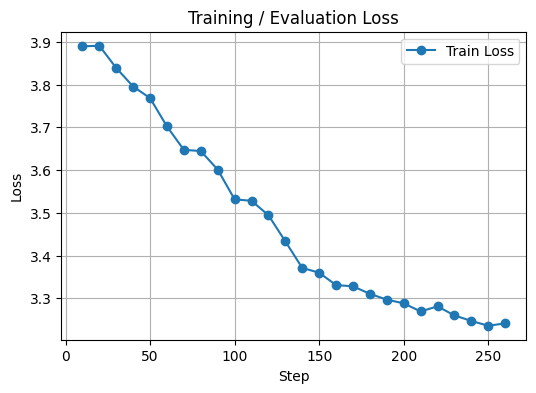

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# แปลง log_history เป็น DataFrame เพื่อจัดการง่าย
df = pd.DataFrame(trainer.state.log_history)

# ===== กราฟ Loss =====
plt.figure(figsize=(6,4))
plt.plot(df["step"], df["loss"], label="Train Loss", marker="o")
if "eval_loss" in df.columns:
    plt.plot(df["step"], df["eval_loss"], label="Eval Loss", marker="x")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training / Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ===== กราฟ Accuracy =====
if "eval_accuracy" in df.columns or "accuracy" in df.columns:
    plt.figure(figsize=(6,4))
    acc_col = "eval_accuracy" if "eval_accuracy" in df.columns else "accuracy"
    plt.plot(df["step"], df[acc_col], label="Eval Accuracy", color="green", marker="x")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.title("Evaluation Accuracy over Steps")
    plt.legend()
    plt.grid(True)
    plt.show()

In [34]:
from datetime import datetime
import os

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = f"lora_model_{timestamp}"

os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"✅ Model saved to: {save_dir}")

✅ Model saved to: lora_model_20251015_194820
